In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [294]:
raw_data = pd.read_csv('generated_values2years.csv')
df = raw_data.copy()

In [295]:
df.columns

Index(['fin_record_key', 'fin_debit_credit_ind', 'fin_company_id',
       'fin_trans_dt', 'fin_source_amt', 'fin_acct_num'],
      dtype='object')

In [296]:
df.drop(['fin_record_key','fin_debit_credit_ind','fin_acct_num','fin_company_id'],axis=1,inplace=True)

In [297]:
df.head()

,fin_trans_dt,fin_source_amt
0,2024-06-21,179.73
1,2024-11-25,450.87
2,2024-09-05,238.07
3,2024-06-30,210.59
4,2024-09-10,283.52


In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fin_trans_dt    2000 non-null   object 
 1   fin_source_amt  2000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.4+ KB


In [299]:
df = df.groupby(df['fin_trans_dt']).agg({'fin_source_amt': 'mean'}).rename(columns={'fin_source_amt': 'mean_amt'}).reset_index()

In [300]:
df['fin_trans_dt'] = pd.to_datetime(df['fin_trans_dt'])

In [301]:
df = df.sort_values('fin_trans_dt')

In [302]:
df.set_index('fin_trans_dt',inplace=True)

In [303]:
df.head()

,mean_amt
fin_trans_dt,
2024-01-01,306.885000
2024-01-02,392.782000
2024-01-03,220.038000
2024-01-04,251.850000
2024-01-05,345.276667


In [304]:
df = df.asfreq('d')

In [311]:
df = df.fillna(method='bfill')

In [312]:
df.isna().sum()

mean_amt          0
day_of_week       0
month             0
quarter           0
year              0
lag_1             0
rolling_mean_7    0
dtype: int64

In [307]:
# Date features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

In [308]:
# Lag features (e.g., lag 1, lag 7)
df['lag_1'] = df['mean_amt'].shift(1)

In [309]:
# Rolling statistics
df['rolling_mean_7'] = df['mean_amt'].rolling(window=7).mean()

In [313]:
df.head()

,mean_amt,day_of_week,month,quarter,year,lag_1,rolling_mean_7
fin_trans_dt,,,,,,,
2024-01-01,306.885000,0,1,1,2024,306.885,305.782381
2024-01-02,392.782000,1,1,1,2024,306.885,305.782381
2024-01-03,220.038000,2,1,1,2024,392.782,305.782381
2024-01-04,251.850000,3,1,1,2024,220.038,305.782381
2024-01-05,345.276667,4,1,1,2024,251.850,305.782381


In [314]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [315]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

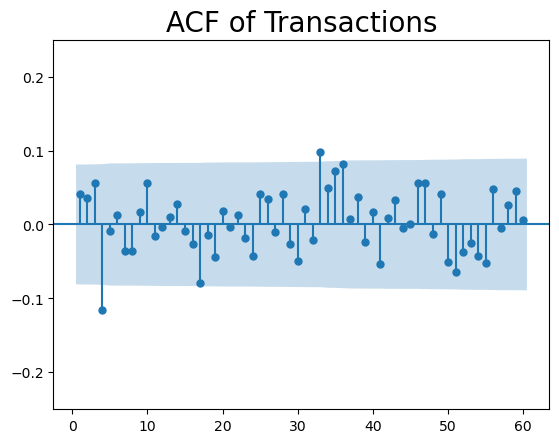

In [316]:
sgt.plot_acf(train['mean_amt'],zero=False,lags=60)
plt.title('ACF of Transactions',size=20)
plt.ylim(-0.25,0.25)
plt.show()

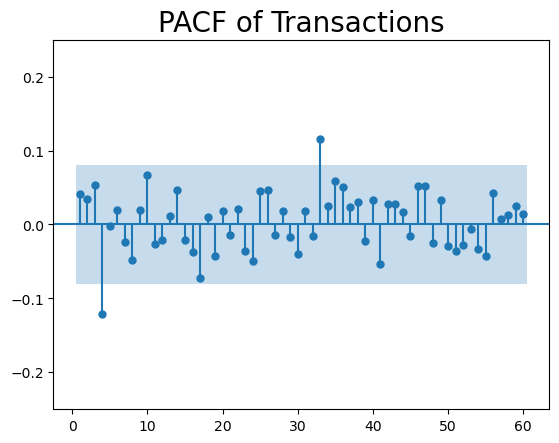

In [317]:
sgt.plot_pacf(train['mean_amt'],zero=False,lags=60)
plt.title('PACF of Transactions',size=20)
plt.ylim(-0.25,0.25)
plt.show()

In [318]:
sts.adfuller(train['mean_amt'])

(-12.635365684391651,
 1.474009113741034e-23,
 3,
 580,
 {'1%': -3.4416749612171467,
  '5%': -2.8665360672844318,
  '10%': -2.5694307639714626},
 6768.810369112394)

In [319]:
# Fit the ARIMA model
model = ARIMA(train['mean_amt'], order=(33,0,17),exog=train[['day_of_week', 'month', 'quarter','lag_1','rolling_mean_7']])
results = model.fit()

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [320]:
# Make out-of-sample predictions for test data
test['Predictions'] = results.predict(start=len(train), end=len(train)+len(test)-1,exog=test[['day_of_week', 'month', 'quarter','lag_1','rolling_mean_7']])

D:\Users\sharesh\AppData\Local\Temp\ipykernel_3244\690178919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = results.predict(start=len(train), end=len(train)+len(test)-1,exog=test[['day_of_week', 'month', 'quarter','lag_1','rolling_mean_7']])


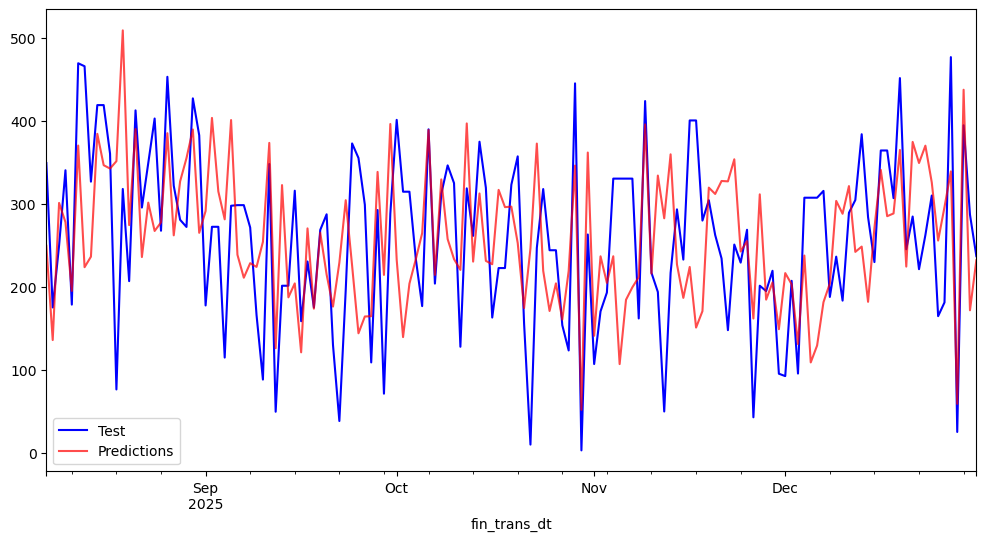

In [321]:
test['mean_amt'].plot(figsize=(12,6),color='blue',label='Test')
test['Predictions'].plot(color='red',alpha=0.7,label='Predictions')
plt.legend()
plt.show()

In [322]:
# Calculate RMSE for forecast
rmse_forecast = np.sqrt(mean_squared_error(test['mean_amt'], test['Predictions']))
print('RMSE for test predictions:', rmse_forecast)

RMSE for test predictions: 102.44519643276357


In [323]:
df['mean_amt'].mean()

251.39009191040753

In [277]:
# # Fit the ARIMA model
# df_model = ARIMA(df['mean_amt'], order=(33, 0, 17), exog=df[['day_of_week', 'month', 'quarter', 'lag_1', 'rolling_mean_7']])
# df_results = df_model.fit()

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Assuming df is your DataFrame with the time series data
# Calculate lag_1 and rolling_mean_7 for the last value of the dataset
lag_1 = df['mean_amt'].iloc[-1]
rolling_mean_7 = df['mean_amt'].iloc[-7:].mean()

# Initialize a list to store forecasted values
forecast_values = []

forecast_date = df.index[-1] + pd.DateOffset(days=1)  # Start forecasting from the next day
end_date = forecast_date + pd.DateOffset(months=1)    # Forecast for one month

while forecast_date <= end_date:
    # Prepare the exogenous variables for the forecast date
    exog = np.array([
        forecast_date.dayofweek,  # day of week
        forecast_date.month,       # month
        forecast_date.quarter,     # quarter
        lag_1,                     # lag_1
        rolling_mean_7             # rolling_mean_7
    ]).reshape(1, -1)  # Reshape the array to have shape (1, -1)
    
     # Replace NaN and infinite values with zeros
    exog = np.nan_to_num(exog, nan=0.0, posinf=0.0, neginf=0.0)

    # Fit the ARIMA model
    df_model = ARIMA(df['mean_amt'], order=(33, 0, 17), exog=df[['day_of_week', 'month', 'quarter', 'lag_1', 'rolling_mean_7']])
    df_results = df_model.fit()

    # Forecast the next value using the fitted model and exogenous variables
    forecast_value = df_results.predict(start=len(df), end=len(df), exog=exog)
    
     # Store the forecasted value and exogenous variables for the current forecast date if not already stored
    if forecast_date not in [item['forecast_date'] for item in forecast_values]:
        forecast_values.append({
            'forecast_date': forecast_date,
            'forecast_value': forecast_value[0],
            'day_of_week': forecast_date.dayofweek,
            'month': forecast_date.month,
            'quarter': forecast_date.quarter,
            'lag_1': lag_1,
            'rolling_mean_7': rolling_mean_7
        })

     # Update lag_1 and rolling_mean_7 for the next iteration
    lag_1 = forecast_value[0]
    rolling_mean_7 = df.loc[forecast_date - pd.DateOffset(days=6):forecast_date, 'mean_amt'].mean()  # Use 7 days including the forecasted value
    forecast_date += pd.DateOffset(days=1)  # Move to the next day for the next forecast

# Convert the list of dictionaries into a DataFrame
forecast_values_df = pd.DataFrame(forecast_values)
print(forecast_values_df)

# Plot the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['mean_amt'], label='Original Data')
plt.plot(forecast_values_df['forecast_date'], forecast_values_df['forecast_value'], label='Forecasted Values', color='red')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.title('Forecasted Transaction Amount for the Next Month')
plt.legend()
plt.show()

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting au

In [280]:
forecast_values_df.columns

Index(['forecast_date', 'forecast_value', 'day_of_week', 'month', 'quarter',
       'lag_1', 'rolling_mean_7'],
      dtype='object')

In [288]:
forecast_values_df.tail()

,forecast_date,forecast_value,day_of_week,month,quarter,lag_1,rolling_mean_7
27,2026-01-28,27.283972,2,1,1,23.933618,NaN
28,2026-01-29,23.304238,3,1,1,27.283972,NaN
29,2026-01-30,24.665985,4,1,1,23.304238,NaN
30,2026-01-31,22.135361,5,1,1,24.665985,NaN
31,2026-02-01,24.289939,6,2,1,22.135361,NaN


In [290]:
# Assuming the index of df and forecast_values_df is not a DatetimeIndex
df.index = pd.to_datetime(df.index)
forecast_values_df.index = pd.to_datetime(forecast_values_df['forecast_date'])

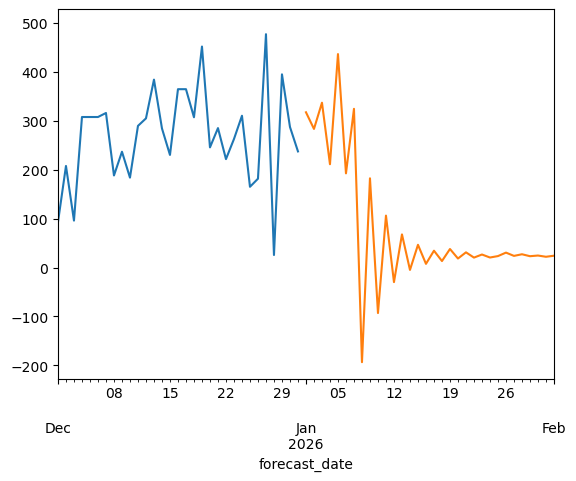

In [292]:
# Plotting
ax = df['mean_amt'].plot()
forecast_values_df['forecast_value'].plot(ax=ax)
plt.xlim('2025-12-01', '2026-02-01')
plt.show()